In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler

In [2]:
def correlate_signatures(input_data: pd.DataFrame, feature_names: list):
    features = input_data[feature_names]
    scaler = StandardScaler()
    features_scale = pd.DataFrame(
        scaler.fit_transform(features), index=features.index, columns=features.columns
    )
    features_r = features_scale.T.corr(method=lambda x, y: pearsonr(x, y)[0])
    features_p = features_scale.T.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(
        *features_r.shape
    )
    features_d = 1 - features_r

    return features_r, features_p, features_d


def label_nodes_by_group(graph, groups):
    nodelabels = {}
    for node in graph.nodes:
        for group in groups.keys():
            if node in groups[group]:
                nodelabels[node] = group
    nx.set_node_attributes(graph, nodelabels, "group")


def make_edge_tuples(from_group, to_group, r_matrix, p_matrix, d_matrix, sig=True):
    edge_tuples = []
    for i in from_group:
        for j in to_group:
            if sig == True:
                if p_matrix.loc[i, j] < 0.05:
                    edge_tuples.append(
                        (
                            r_matrix.index[i - 1],
                            r_matrix.index[j - 1],
                            {"weight": 2 - d_matrix.loc[i, j]},
                        )
                    )
            else:
                edge_tuples.append(
                    (
                        r_matrix.index[i - 1],
                        r_matrix.index[j - 1],
                        {"weight": 2 - d_matrix.loc[i, j]},
                    )
                )
    return edge_tuples


def permute_labels(input_data: pd.DataFrame):
    generator = np.random.default_rng()
    permuted_group = pd.Series(
        generator.permutation(input_data["patient_period"]), index=input_data.index
    )
    node_groups = {
        "untreat": list(permuted_group.index[permuted_group == "ART_untreat"]),
        "short": list(permuted_group.index[permuted_group == "ART_short"]),
        "long": list(permuted_group.index[permuted_group == "ART_long"]),
        "ec": list(permuted_group.index[permuted_group == "EC_long"]),
    }
    return node_groups


def do_random_walk(graph: nx.DiGraph, source_group: str, n: int, weight="weight"):
    if source_group == "all":
        sources = [node for node in graph.nodes]
    else:
        sources = [
            node for node in graph.nodes if (graph.nodes[node]["group"] == source_group)
        ]
    source = random.choice(sources)
    p = 1.0
    current_node = source
    current_out_deg = graph.out_degree(current_node, weight=weight)
    current_out_edges = graph.out_edges(current_node, data=True)
    targets = [edge[1] for edge in current_out_edges]
    ps = [edge[2]["weight"] / (current_out_deg) for edge in current_out_edges]

    for _ in range(n):
        if current_out_deg != 0:
            target = random.choices(population=targets, weights=ps, k=1)[0]
            p = (graph.edges[(current_node, target)][weight] / current_out_deg) * p
            current_node = target
            current_out_deg = graph.out_degree(current_node, weight=weight)
            current_out_edges = graph.out_edges(current_node, data=True)
            targets = [edge[1] for edge in current_out_edges]
            ps = [edge[2]["weight"] / (current_out_deg) for edge in current_out_edges]

    return graph.nodes[current_node]["group"]


def monte_carlo_random_walk(
    graph: nx.DiGraph, source_group: str, i: int, n: int
) -> np.float64:
    walk_ends = {"ec": 0, "long": 0, "short": 0, "untreat": 0}
    for _ in range(i):
        walk_end = do_random_walk(graph, source_group, n)
        walk_ends[walk_end] += 1

    random_walk_p_distr = {
        group: 100 * k / sum(walk_ends.values()) for group, k in walk_ends.items()
    }
    # random_p_ec = random_walk_p_distr["ec"]
    return random_walk_p_distr


def random_walk_wrapper(
    groups: dict,
    matrices: dict,
    source_group: str = "all",
    i: int = None,
    n: int = None,
    return_graphs: bool = False,
):
    graphs_and_walks = {}
    edge_groups = {}
    for category, category_matrices in matrices.items():
        for source_key, source in groups.items():
            for target_key, target in groups.items():
                edge_tuples = make_edge_tuples(
                    source,
                    target,
                    category_matrices[0],
                    category_matrices[1],
                    category_matrices[2],
                )
                edge_groups[f"{category}_{source_key}_to_{target_key}"] = edge_tuples
        sc3_edges = (
            edge_groups[f"{category}_untreat_to_short"]
            + edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_untreat_to_ec"]
            + edge_groups[f"{category}_short_to_ec"]
            + edge_groups[f"{category}_untreat_to_long"]
            + edge_groups[f"{category}_long_to_ec"]
        )
        sc2_edges = (
            edge_groups[f"{category}_untreat_to_short"]
            + edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_untreat_to_ec"]
            + edge_groups[f"{category}_short_to_ec"]
            + edge_groups[f"{category}_untreat_to_long"]
            + edge_groups[f"{category}_ec_to_long"]
        )
        sc1_edges = (
            edge_groups[f"{category}_untreat_to_short"]
            + edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_untreat_to_ec"]
            + edge_groups[f"{category}_short_to_ec"]
            + edge_groups[f"{category}_untreat_to_long"]
        )
        sc4_edges = (
            edge_groups[f"{category}_untreat_to_short"]
            + edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_untreat_to_ec"]
            + edge_groups[f"{category}_short_to_ec"]
            + edge_groups[f"{category}_untreat_to_long"]
            + edge_groups[f"{category}_ec_to_long"]
            + edge_groups[f"{category}_long_to_ec"]
        )
        sc3_graph = nx.from_edgelist(sc3_edges, create_using=nx.DiGraph)
        sc2_graph = nx.from_edgelist(sc2_edges, create_using=nx.DiGraph)
        sc1_graph = nx.from_edgelist(sc1_edges, create_using=nx.DiGraph)
        sc4_graph = nx.from_edgelist(sc4_edges, create_using=nx.DiGraph)
        label_nodes_by_group(sc3_graph, groups)
        label_nodes_by_group(sc2_graph, groups)
        label_nodes_by_group(sc1_graph, groups)
        label_nodes_by_group(sc4_graph, groups)

        sc3_walk = monte_carlo_random_walk(sc3_graph, source_group, i, n)
        sc2_walk = monte_carlo_random_walk(sc2_graph, source_group, i, n)
        sc1_walk = monte_carlo_random_walk(sc1_graph, source_group, i, n)
        sc4_walk = monte_carlo_random_walk(sc4_graph, source_group, i, n)
        if return_graphs == True:
            graphs_and_walks[category] = {
                "sc3": (sc3_graph, sc3_walk),
                "sc2": (sc2_graph, sc2_walk),
                "sc1": (sc1_graph, sc1_walk),
                "sc4": (sc4_graph, sc4_walk),
            }
        else:
            graphs_and_walks[category] = {
                "sc3": sc3_walk,
                "sc2": sc2_walk,
                "sc1": sc1_walk,
                "sc4": sc4_walk,
            }

    return graphs_and_walks


def random_walk_wrapper_sh(
    groups: dict,
    matrices: dict,
    source_group: str = "all",
    i: int = None,
    n: int = None,
    return_graphs: bool = False,
):
    graphs_and_walks = {}
    edge_groups = {}
    for category, category_matrices in matrices.items():
        for source_key, source in groups.items():
            for target_key, target in groups.items():
                edge_tuples = make_edge_tuples(
                    source,
                    target,
                    category_matrices[0],
                    category_matrices[1],
                    category_matrices[2],
                )
                edge_groups[f"{category}_{source_key}_to_{target_key}"] = edge_tuples
        sc3_edges = (
            edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_short_to_ec"]
            + edge_groups[f"{category}_long_to_ec"]
        )
        sc2_edges = (
            edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_short_to_ec"]
            + edge_groups[f"{category}_ec_to_long"]
        )
        sc1_edges = (
            edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_short_to_ec"]
        )
        sc4_edges = (
            edge_groups[f"{category}_short_to_long"]
            + edge_groups[f"{category}_short_to_ec"]
            + edge_groups[f"{category}_ec_to_long"]
            + edge_groups[f"{category}_long_to_ec"]
        )
        sc3_graph = nx.from_edgelist(sc3_edges, create_using=nx.DiGraph)
        sc2_graph = nx.from_edgelist(sc2_edges, create_using=nx.DiGraph)
        sc1_graph = nx.from_edgelist(sc1_edges, create_using=nx.DiGraph)
        sc4_graph = nx.from_edgelist(sc4_edges, create_using=nx.DiGraph)
        label_nodes_by_group(sc3_graph, groups)
        label_nodes_by_group(sc2_graph, groups)
        label_nodes_by_group(sc1_graph, groups)
        label_nodes_by_group(sc4_graph, groups)

        sc3_walk = monte_carlo_random_walk(sc3_graph, source_group, i, n)
        sc2_walk = monte_carlo_random_walk(sc2_graph, source_group, i, n)
        sc1_walk = monte_carlo_random_walk(sc1_graph, source_group, i, n)
        sc4_walk = monte_carlo_random_walk(sc4_graph, source_group, i, n)
        if return_graphs == True:
            graphs_and_walks[category] = {
                "sc3": (sc3_graph, sc3_walk),
                "sc2": (sc2_graph, sc2_walk),
                "sc1": (sc1_graph, sc1_walk),
                "sc4": (sc4_graph, sc4_walk),
            }
        else:
            graphs_and_walks[category] = {
                "sc3": sc3_walk,
                "sc2": sc2_walk,
                "sc1": sc1_walk,
                "sc4": sc4_walk,
            }

    return graphs_and_walks



In [3]:
long_sig = pd.read_excel("data/Table_6.xlsx", index_col = "id")
long_sig = long_sig.drop(["Description", "patient", "period"], axis=1)

In [4]:
node_groups = {
    "untreat": list(long_sig.index[long_sig["patient_period"] == "ART_untreat"]),
    "short": list(long_sig.index[long_sig["patient_period"] == "ART_short"]),
    "long": list(long_sig.index[long_sig["patient_period"] == "ART_long"]),
    "ec": list(long_sig.index[long_sig["patient_period"] == "EC_long"]),
}

cat1_features = [
    "is_other_cell",
    "is_CD4_T_cell",
    "is_CD8_T_cell",
    "is_B_cell",
    "is_myeloid_cell",
    "is_proinflammatory_factor",
    "Response",
    "Count",
    "Rich_factor",
]
cat2_features = ["tpm"]
cat3_features = ["HiC","atac_seq_ count"]

cat_groups = {'cat1': cat1_features, 'cat12': cat1_features+cat2_features, 'cat13': cat1_features+cat3_features, 'cat123': cat1_features+cat2_features+cat3_features}


In [5]:
for name, group in node_groups.items():
    print(f"{name}: {len(group)}")

untreat: 8
short: 65
long: 153
ec: 22


In [6]:
features_matrices = {}
for group_name, group_features in cat_groups.items():
    features_matrices[group_name] = correlate_signatures(long_sig, group_features)

Pearson correlation distances, data for Figure 4 K-O.

In [7]:
group_distances = {}
group_pvalues = {}
for group in cat_groups.keys():
    temp_distance_matrix = pd.DataFrame(
        0.0, index=node_groups.keys(), columns=node_groups.keys()
    )
    temp_pvalue_matrix = pd.DataFrame(index=node_groups.keys(), columns=node_groups.keys()
    )
    for node_group1 in node_groups.keys():
        for node_group2 in node_groups.keys():
            dist_array = features_matrices[group][2].loc[
                node_groups[node_group1], node_groups[node_group2]
            ][
                (
                    features_matrices[group][1].loc[
                        node_groups[node_group1], node_groups[node_group2]
                    ]
                )
                < 0.05
            ].values
            dist_array = dist_array[~np.isnan(dist_array)]
            temp_distance_matrix.loc[node_group1, node_group2] = np.mean(dist_array)
            temp_pvalue_matrix.loc[node_group1,node_group2] = dist_array
    group_distances[group] = temp_distance_matrix
    group_pvalues[group] = temp_pvalue_matrix

In [8]:
for group, df in group_distances.items():
    df.to_csv(f"data/output/{group}_distances.csv")

Markov Chain Monte Carlo on networks with assumed directionality

In [9]:
real_mc_p = random_walk_wrapper(node_groups, features_matrices, source_group="untreat", i=10000, n=10)
real_mc_p['cat1']

{'sc3': {'ec': 45.78, 'long': 54.22, 'short': 0.0, 'untreat': 0.0},
 'sc2': {'ec': 0.2, 'long': 99.8, 'short': 0.0, 'untreat': 0.0},
 'sc1': {'ec': 15.21, 'long': 84.79, 'short': 0.0, 'untreat': 0.0},
 'sc4': {'ec': 21.8, 'long': 78.2, 'short': 0.0, 'untreat': 0.0}}

In [10]:
random_mc_controls = {}

for category in features_matrices.keys():
    random_mc_controls[category] = {"sc3": [], "sc2": [], "sc1": [], "sc4":[]}
    for iters in range(100):
        print(f"{category}, {iters}", end='\r', flush=True)
        random_node_groups = permute_labels(long_sig)
        random_p = random_walk_wrapper(
            random_node_groups, features_matrices, source_group="untreat", i=10000, n=10
        )
        random_mc_controls[category]["sc3"].append(random_p[category]["sc3"])
        random_mc_controls[category]["sc2"].append(random_p[category]["sc2"])
        random_mc_controls[category]["sc1"].append(random_p[category]["sc1"])
        random_mc_controls[category]["sc4"].append(random_p[category]["sc4"])

73.13 45.78 

0.0 0.2 

12.09 15.21 

49.215 21.8 



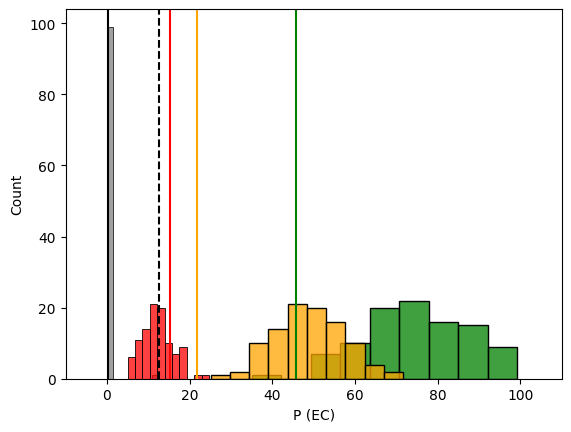

In [11]:
fig, ax = plt.subplots()
sns.histplot([walk['ec'] for walk in random_mc_controls['cat1']['sc3']],color="green")
plt.axvline(real_mc_p["cat1"]["sc3"]["ec"], color="green")
sns.histplot([walk['ec'] for walk in random_mc_controls['cat1']['sc2']],color="grey")
plt.axvline(real_mc_p["cat1"]["sc2"]["ec"], color="black")
sns.histplot([walk['ec'] for walk in random_mc_controls['cat1']['sc1']],color="red")
plt.axvline(real_mc_p["cat1"]["sc1"]["ec"], color="red")
sns.histplot([walk['ec'] for walk in random_mc_controls['cat1']['sc4']],color="orange")
plt.axvline(real_mc_p["cat1"]["sc4"]["ec"], color="orange")
plt.axvline(12.6, color="black", linestyle="dashed")
ax.set_xlim(-10, 110)
ax.set_xlabel("P (EC)")
print(np.median([walk['ec'] for walk in random_mc_controls['cat1']['sc3']]), real_mc_p["cat1"]["sc3"]["ec"],"\n")
print(np.median([walk['ec'] for walk in random_mc_controls['cat1']['sc2']]), real_mc_p["cat1"]["sc2"]["ec"],"\n")
print(np.median([walk['ec'] for walk in random_mc_controls['cat1']['sc1']]), real_mc_p["cat1"]["sc1"]["ec"],"\n")
print(np.median([walk['ec'] for walk in random_mc_controls['cat1']['sc4']]), real_mc_p["cat1"]["sc4"]["ec"],"\n")
plt.savefig("data/output/random_walk_cat1_full.svg", format="svg")

In [12]:
real_mc_sh_p = random_walk_wrapper_sh(node_groups, features_matrices, source_group="short", i=10000, n=10)
real_mc_p['cat1']

{'sc3': {'ec': 45.78, 'long': 54.22, 'short': 0.0, 'untreat': 0.0},
 'sc2': {'ec': 0.2, 'long': 99.8, 'short': 0.0, 'untreat': 0.0},
 'sc1': {'ec': 15.21, 'long': 84.79, 'short': 0.0, 'untreat': 0.0},
 'sc4': {'ec': 21.8, 'long': 78.2, 'short': 0.0, 'untreat': 0.0}}

In [13]:
random_mc_sh_controls = {}

for category in features_matrices.keys():
    random_mc_sh_controls[category] = {"sc3": [], "sc2": [], "sc1": [], "sc4":[]}
    for iters in range(100):
        print(f"{category}, {iters}", end='\r', flush=True)
        random_node_groups = permute_labels(long_sig)
        random_p = random_walk_wrapper_sh(
            random_node_groups, features_matrices, source_group="short", i=10000, n=10
        )
        random_mc_sh_controls[category]["sc3"].append(random_p[category]["sc3"])
        random_mc_sh_controls[category]["sc2"].append(random_p[category]["sc2"])
        random_mc_sh_controls[category]["sc1"].append(random_p[category]["sc1"])
        random_mc_sh_controls[category]["sc4"].append(random_p[category]["sc4"])

77.71000000000001 45.97 

0.0 0.95 

12.245000000000001 11.78 

64.74000000000001 36.1 



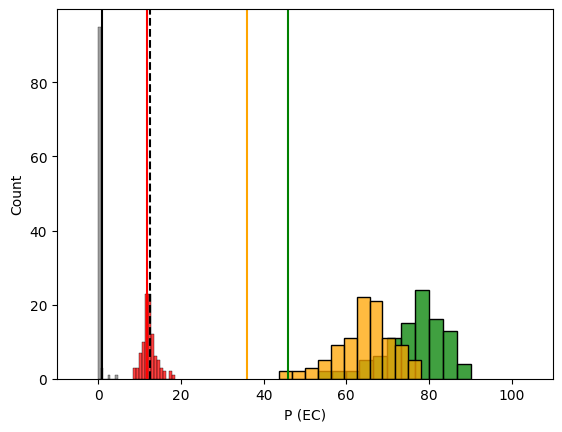

In [14]:
fig, ax = plt.subplots()
sns.histplot([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc3']],color="green")
plt.axvline(real_mc_sh_p["cat1"]["sc3"]["ec"], color="green")
sns.histplot([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc2']],color="grey")
plt.axvline(real_mc_sh_p["cat1"]["sc2"]["ec"], color="black")
sns.histplot([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc1']],color="red")
plt.axvline(real_mc_sh_p["cat1"]["sc1"]["ec"], color="red")
sns.histplot([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc4']],color="orange")
plt.axvline(real_mc_sh_p["cat1"]["sc4"]["ec"], color="orange")
plt.axvline(12.6, color="black", linestyle="dashed")
ax.set_xlim(-10, 110)
ax.set_xlabel("P (EC)")
print(np.median([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc3']]), real_mc_sh_p["cat1"]["sc3"]["ec"],"\n")
print(np.median([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc2']]), real_mc_sh_p["cat1"]["sc2"]["ec"],"\n")
print(np.median([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc1']]), real_mc_sh_p["cat1"]["sc1"]["ec"],"\n")
print(np.median([walk['ec'] for walk in random_mc_sh_controls['cat1']['sc4']]), real_mc_sh_p["cat1"]["sc4"]["ec"],"\n")
plt.savefig("data/output/random_walk_cat1_sh.svg", format="svg")